### Análisis de Efecto Diferencial de El Niño-Southern Oscillation (ENSO) sobre la Productividad de Caña Pantaleon Nicaragua

El Índice Océanico del Niño (Oceanic Niño Index ONI) se ha convertido en el *estándar de-facto* que el NOAA (National Oceanic and Atmospheric Administration) utiliza para clasificar eventos de **El Niño** (calientes) y **La Niña** (fríos) en el Pacífico Oriental Tropical (también conocido como El Niño Southern Oscillation ENSO). Consiste en **la media móvil consecutiva trimestral** de la temperatura superficial del óceano (Sea Surface Temperature o SST) en la *región Niño 3.4* (i.e., 5oN-5oS, 120o-170oW) que está por arriba (o por debajo) del umbral de +0.5°C (-0.5°C). 

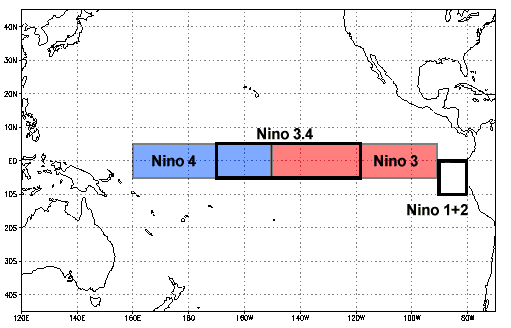

El umbral se descompone posteriormente en **Débil** (con una anomalía SST entre |0.5| y |0.9|), **Moderada** (|1.0| a |1.4|), **Fuerte** (|1.5| a |1.9|) y **Muy Fuerte** (≥ |2.0|).

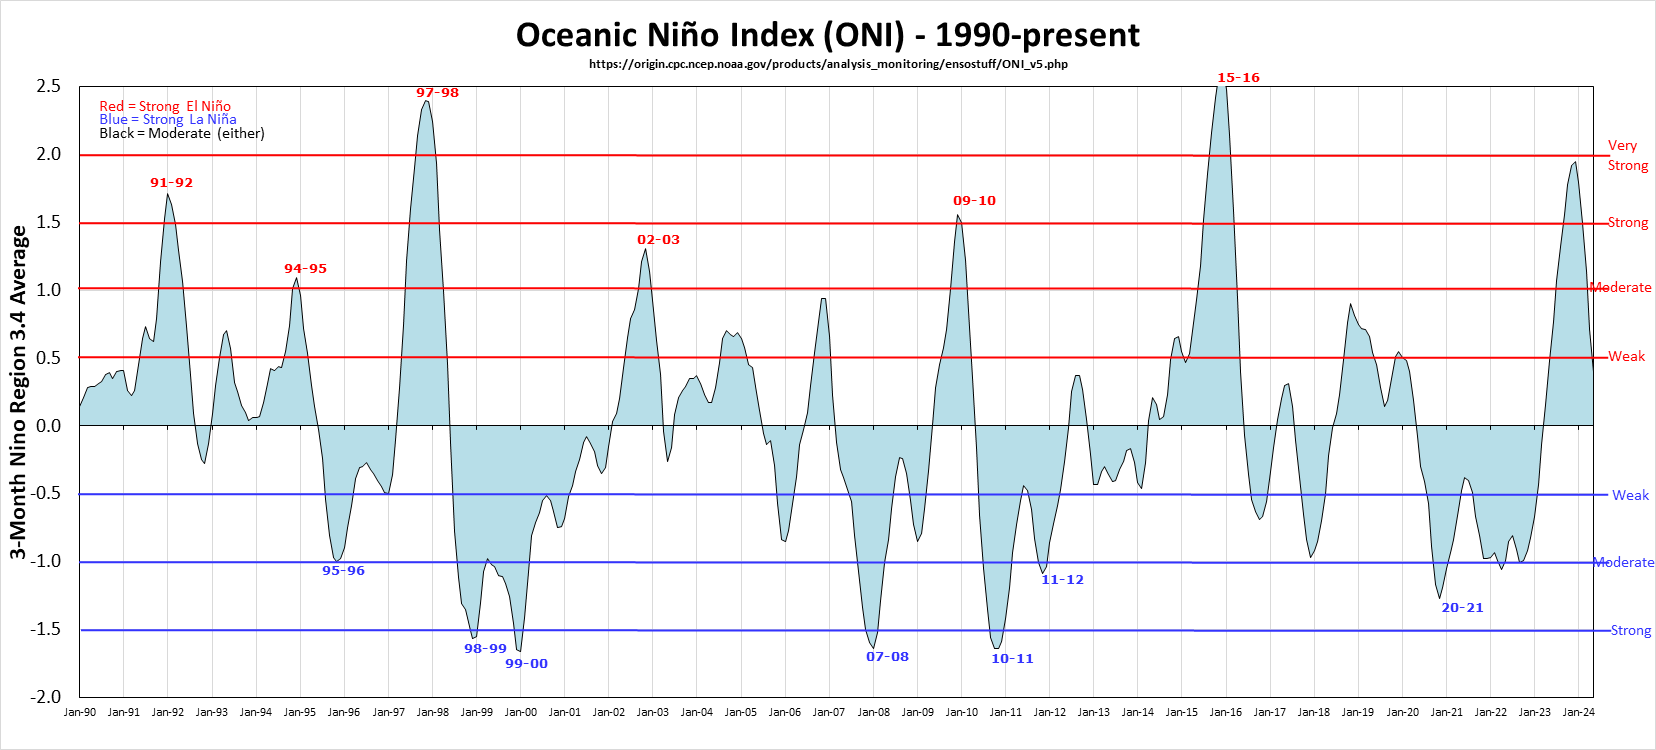

*   https://ggweather.com/enso/oni.htm
*   https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

El siguiente trabajo estudia la relación entre la intensidad de los fenómenos de *El Niño / La Niña* (medida como intensidad de la anomalía ONI) y el Rendimiento de Caña (toneladas de caña por hectárea TCH) para Ingenio Monte Rosa, Nicaragua.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster

from sklearn.ensemble import RandomForestRegressor

### Dataset Rendimientos de Caña en Ingenio Monte Rosa Guatemala

Este dataset contiene la agregación anual de caña cosechada y área cosechada, cuyo cociente determina el rendimiento de caña del año **TCH** (t caña/hectárea). Así mismo, la cantidad de azúcar medida en el Core Sampler determina el rendimiento de azúcar del año **Rend** (kg Azúcar/t caña).

In [2]:
# .csv Nicaragua Yield Data
ni_yield_df = pd.read_csv("Yield_NI.csv")
ni_yield_df['Year'] = pd.to_datetime(ni_yield_df['Año'],format='%Y') + pd.offsets.YearEnd()
ni_yield_df = ni_yield_df.set_index('Year')
ni_yield_df

,Año,TCH,Rend
Year,,,
2005-12-31,2005,92.620545,NaN
2006-12-31,2006,83.701990,NaN
2007-12-31,2007,90.596794,NaN
2008-12-31,2008,82.442004,NaN
2009-12-31,2009,78.479834,NaN
2010-12-31,2010,86.777073,NaN
2011-12-31,2011,87.713152,NaN
2012-12-31,2012,98.015574,132.766181
2013-12-31,2013,106.013302,129.845533


<Axes: title={'center': 'Rendimiento Caña Ingenio Monte Rosa Nicaragua'}, xlabel='Year'>

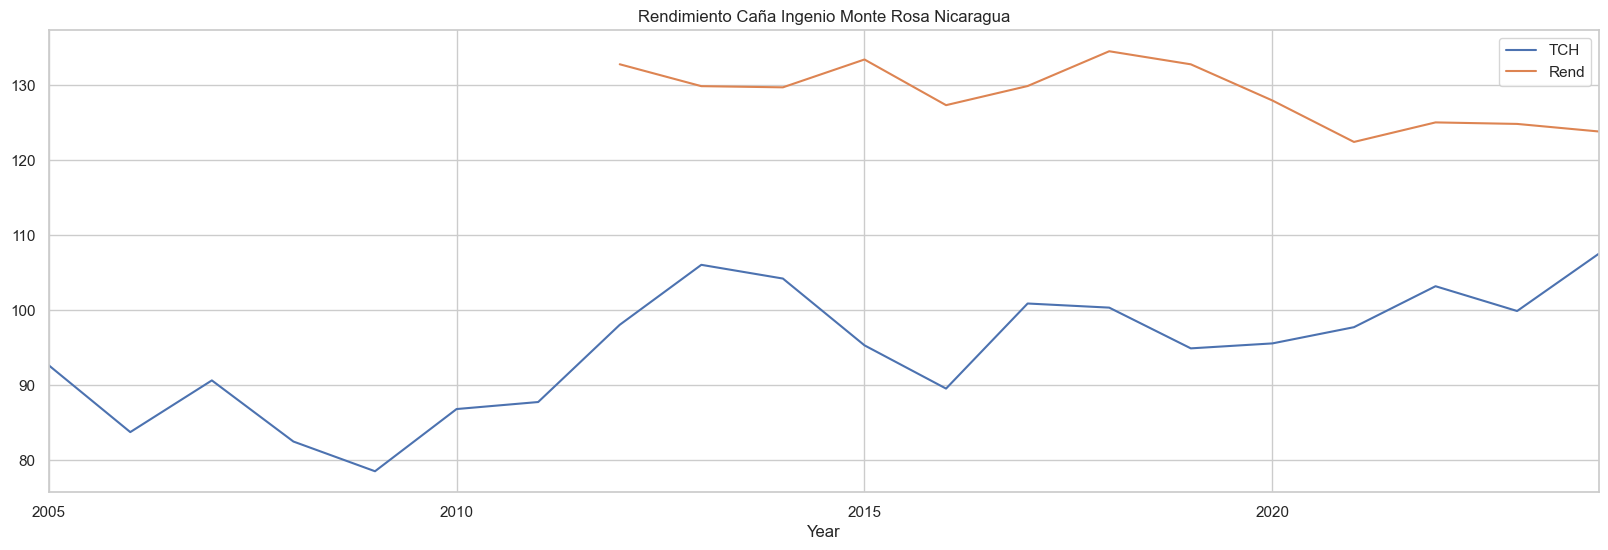

In [3]:
sns.set_theme(style="whitegrid")
ni_yield_df[['TCH','Rend']].plot(figsize=(20,6),grid=True,title='Rendimiento Caña Ingenio Monte Rosa Nicaragua')

### Dataset ONI

Este dataset contiene valores de la anomalía SST en la región 3.4 de El Niño.

In [4]:
# .csv Oceanic Niño Index Data
oni_df = pd.read_csv("ONI_2024.csv")
oni_df['ONI'] = oni_df['Anomaly'].rolling(3).mean()
oni_df.dropna(inplace=True)
oni_df = oni_df[oni_df['Year'] >= 2005]
oni_df = oni_df.groupby('Year').mean()
oni_df['Year'] = oni_df.index
oni_df['Year'] = pd.to_datetime(oni_df['Year'],format='%Y') + pd.offsets.YearEnd()
oni_df = oni_df.set_index('Year')
oni_df

,Month,Total,Clim_Adjust,Anomaly,ONI
Year,,,,,
2005-12-31,6.5,27.096667,27.055833,0.041667,0.168611
2006-12-31,6.5,27.170000,27.082500,0.087500,-0.075000
2007-12-31,6.5,26.464167,27.082500,-0.617500,-0.396389
2008-12-31,6.5,26.297500,27.082500,-0.784167,-0.853889
2009-12-31,6.5,27.369167,27.082500,0.285833,0.088889
2010-12-31,6.5,26.594167,27.082500,-0.486667,-0.215833
2011-12-31,6.5,26.218333,27.082500,-0.864167,-0.907500
2012-12-31,6.5,26.943333,27.082500,-0.140000,-0.221389
2013-12-31,6.5,26.760833,27.082500,-0.319167,-0.315556


Para unir los datasets, se considera que los efectos de un año **Niño / Niña** sobre la caña pueden verse en un año posterior, se desplaza hacia adelante **un año** la serie de anomalías, para que el valor de anomalía del año anterior se asocie al dato de rendimiento actual.

In [5]:
df = pd.concat([oni_df,ni_yield_df],axis=1)
df = df[['TCH','Rend','Anomaly','ONI','Año']]
df['Anomaly'] = df.Anomaly.shift(1)
df['ONI'] = df.ONI.shift(1)
df = df.iloc[1:]
df

,TCH,Rend,Anomaly,ONI,Año
Year,,,,,
2006-12-31,83.701990,NaN,0.041667,0.168611,2006
2007-12-31,90.596794,NaN,0.087500,-0.075000,2007
2008-12-31,82.442004,NaN,-0.617500,-0.396389,2008
2009-12-31,78.479834,NaN,-0.784167,-0.853889,2009
2010-12-31,86.777073,NaN,0.285833,0.088889,2010
2011-12-31,87.713152,NaN,-0.486667,-0.215833,2011
2012-12-31,98.015574,132.766181,-0.864167,-0.907500,2012
2013-12-31,106.013302,129.845533,-0.140000,-0.221389,2013
2014-12-31,104.181965,129.688500,-0.319167,-0.315556,2014


### Tendencia en Rendimientos

Como puede observarse en la serie temporal de rendimientos, **existe una tendencia creciente identificable a incrementar** año con año. Esta tendencia puede deberse a diversos factores, entre ellos por ejemplo, mejoras en manejo de plantación, proyectos de mejora, investigación, etc. Dado que el efecto climático es **oscilante** en el tiempo, es necesario aislar los efectos de mejora en el manejo de las oscilaciones climáticas.

Para ello se debe **remover** la tendencia de la serie temporal de TCH, con el objetivo de estudiar las oscilaciones. Es decir, dado un comportamiento medio dado por las mejoras en el tiempo, cuál es la variación (positiva o negativa) debida a la acción climática del fenómeno del El Niño / La Niña.

Para remover la tendencia, se genera primero una *regresión lineal* ajustada por *Ordinary Least Squares*, para restarla de la serie temporal. Esto generará los residuos que hipotéticamente tendrán correlación con las oscilaciones climáticas.

In [6]:
# Multivariate OLS
OLS_model = smf.ols("TCH ~ Año",data=df).fit()
OLS_model.summary()

/Users/sergiobarrios/anaconda3/envs/PantaleonDS/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TCH   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     17.43
Date:                Thu, 18 Jul 2024   Prob (F-statistic):           0.000636
Time:                        10:58:31   Log-Likelihood:                -60.096
No. Observations:                  19   AIC:                             124.2
Df Residuals:                      17   BIC:                             126.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2035.6939    510.386     -3.989      0.001   -3112.514    -958.874
Año            1.0573      0.253      4.174      0.001       0.523       1.592
==============================================================================
Omnibus:                        1.901   Durbin-Watson:                   1.155
Prob(Omnibus):                  0.387   Jarque-Bera (JB):                1.181
Skew:                           0.608   Prob(JB):                        0.554
Kurtosis:                       2.875   Cond. No.                     7.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
# Generate Predictions
explanatories = ['Año']
ex_hat = OLS_model.predict(df[explanatories])

Text(0.5, 1.0, 'TCH Nicaragua')

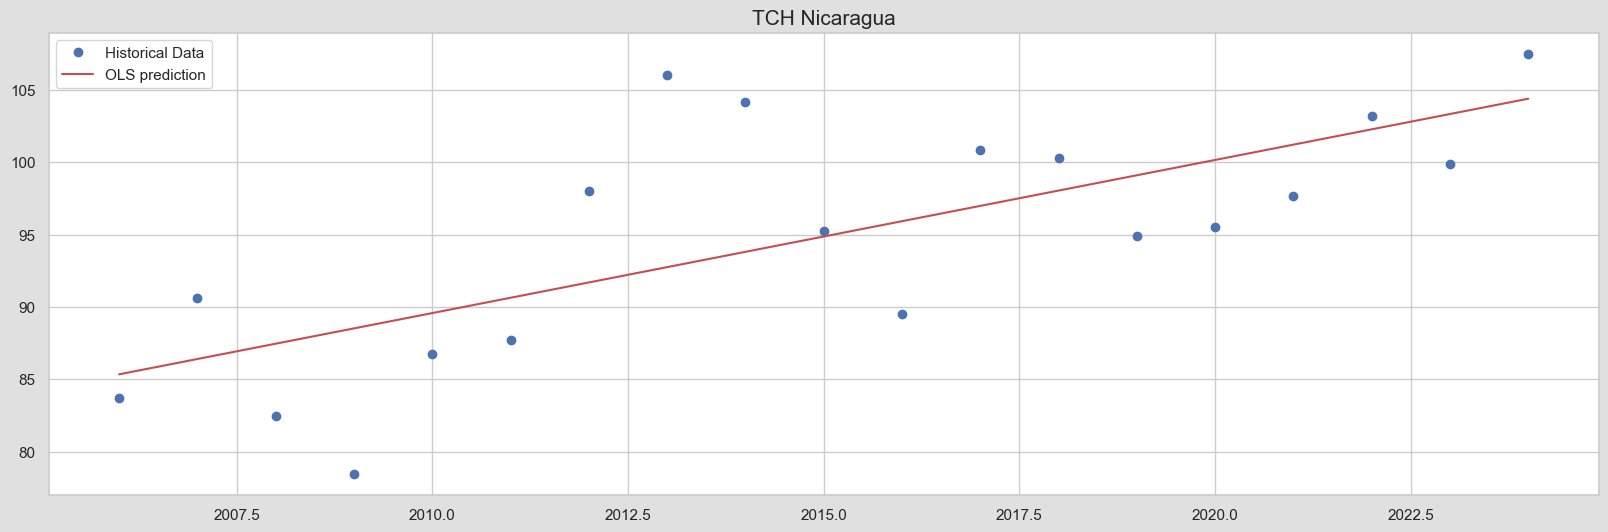

In [8]:
# Plot Predictions vs. Actuals
fig, ax = plt.subplots(figsize=(20,6))
fig.patch.set_facecolor('#E0E0E0')
plt.grid(zorder=0)
ax.plot(df['Año'], df['TCH'], "o", label="Historical Data")
ax.plot(df['Año'], ex_hat, "r", label="OLS prediction")
ax.legend(loc="best")
plt.title("TCH Nicaragua",size=15)

### Análisis de Residuos

Se calculan los residuos restando de la serie temporal la tendencia obtenida.
Adicionalmente se calculan variables categóricas para indicar si un año es Niño, Niña o Neutro.

In [9]:
# Detrending for Residuals
threshold = 0.5
df['TCH Trend'] = ex_hat.values
df['TCH Residuals'] = df['TCH'] - df['TCH Trend']
df['NINO'] = (df['ONI'] > threshold).astype(int)
df['NINA'] = (df['ONI'] < -threshold).astype(int)
df['NEUTRO'] = ((df['ONI'] <= threshold) & (df['ONI'] >= -threshold)).astype(int)
df.dropna(inplace=True)
df

,TCH,Rend,Anomaly,ONI,Año,TCH Trend,TCH Residuals,NINO,NINA,NEUTRO
Year,,,,,,,,,,
2012-12-31,98.015574,132.766181,-0.864167,-0.907500,2012,91.694172,6.321402,0,1,0
2013-12-31,106.013302,129.845533,-0.140000,-0.221389,2013,92.751522,13.261780,0,0,1
2014-12-31,104.181965,129.688500,-0.319167,-0.315556,2014,93.808872,10.373093,0,0,1
2015-12-31,95.274645,133.402096,0.114167,0.040000,2015,94.866222,0.408423,0,0,1
2016-12-31,89.506545,127.310177,1.457500,1.295833,2016,95.923572,-6.417026,1,0,0
2017-12-31,100.854567,129.862183,0.330833,0.602222,2017,96.980922,3.873645,1,0,0
2018-12-31,100.304748,134.501741,-0.202500,-0.169722,2018,98.038272,2.266476,0,0,1
2019-12-31,94.871300,132.759026,0.012500,-0.143611,2019,99.095622,-4.224322,0,0,1
2020-12-31,95.532215,127.935817,0.477500,0.508611,2020,100.152971,-4.620757,1,0,0


### Serie Temporal de Residuos y Anomalías

<Axes: title={'center': 'Yield Nicaragua'}, xlabel='Year'>

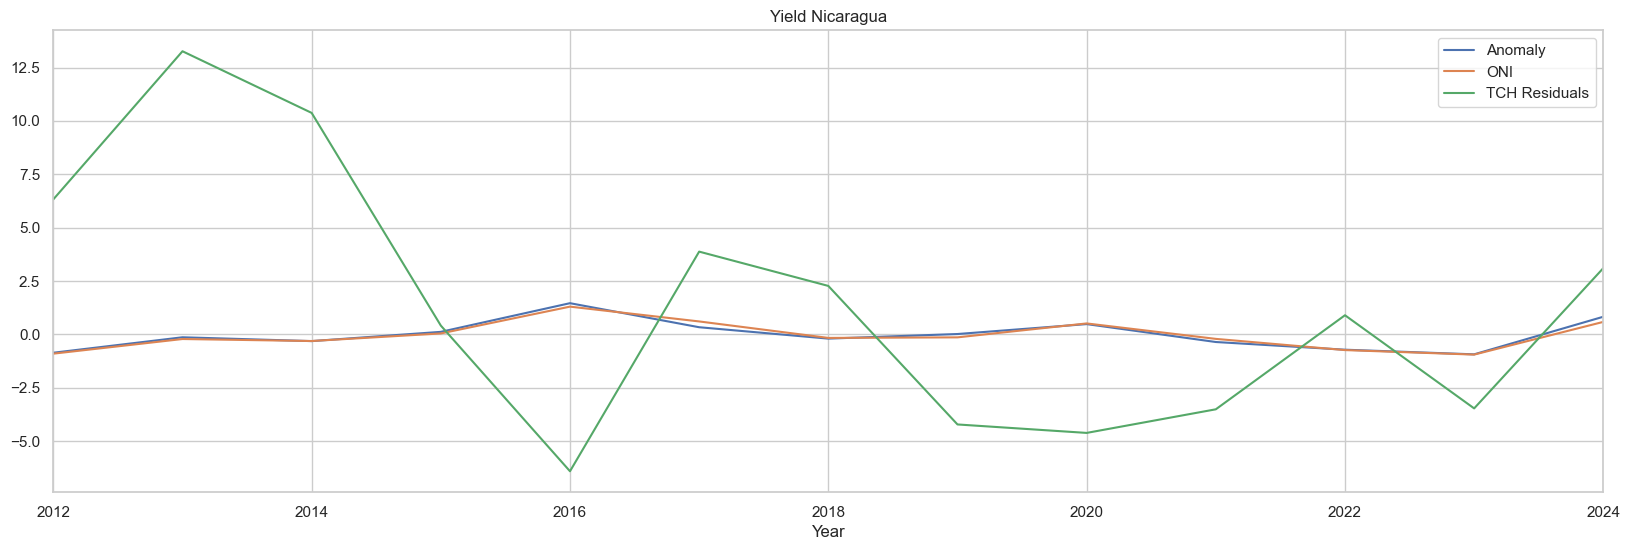

In [10]:
df[['Anomaly','ONI','TCH Residuals']].plot(figsize=(20,6),grid=True,title='Yield Nicaragua')

### Correlograma TCH

Se muestra un correlograma para identificar las variables que estén mayormente correlacionadas con el TCH y los residuos de TCH después de la remoción de la tendencia.

<Axes: title={'center': 'Correlograma TCH Nicaragua'}>

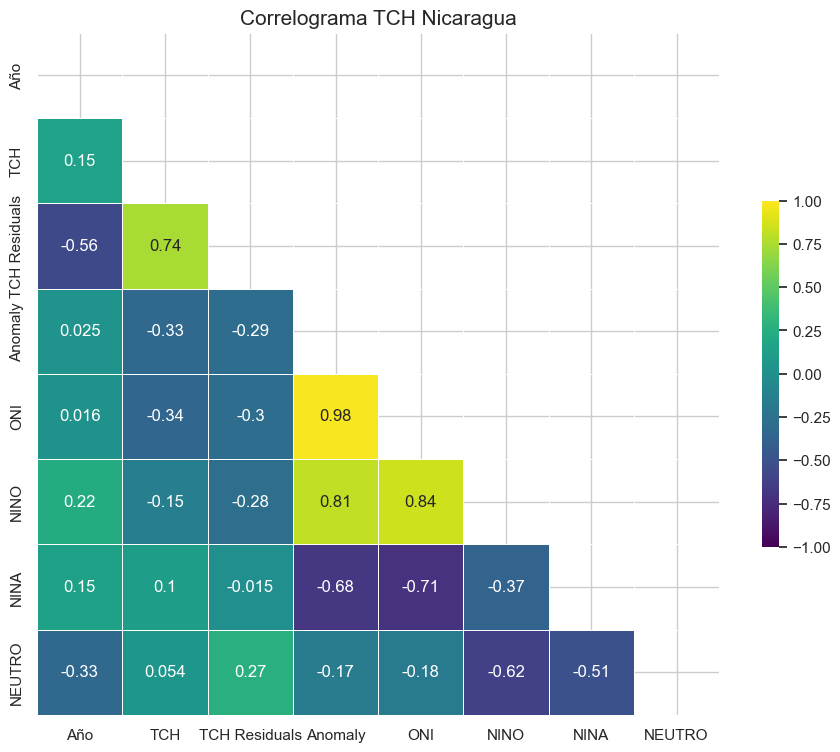

In [11]:
# Compute the correlation matrix
corr = df[['Año','TCH','TCH Residuals','Anomaly','ONI','NINO','NINA','NEUTRO']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="darkgrid")
plt.title("Correlograma TCH Nicaragua",size=15)
cmap = 'viridis'
sns.heatmap(corr, mask=mask, vmin = -1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, cmap = cmap)

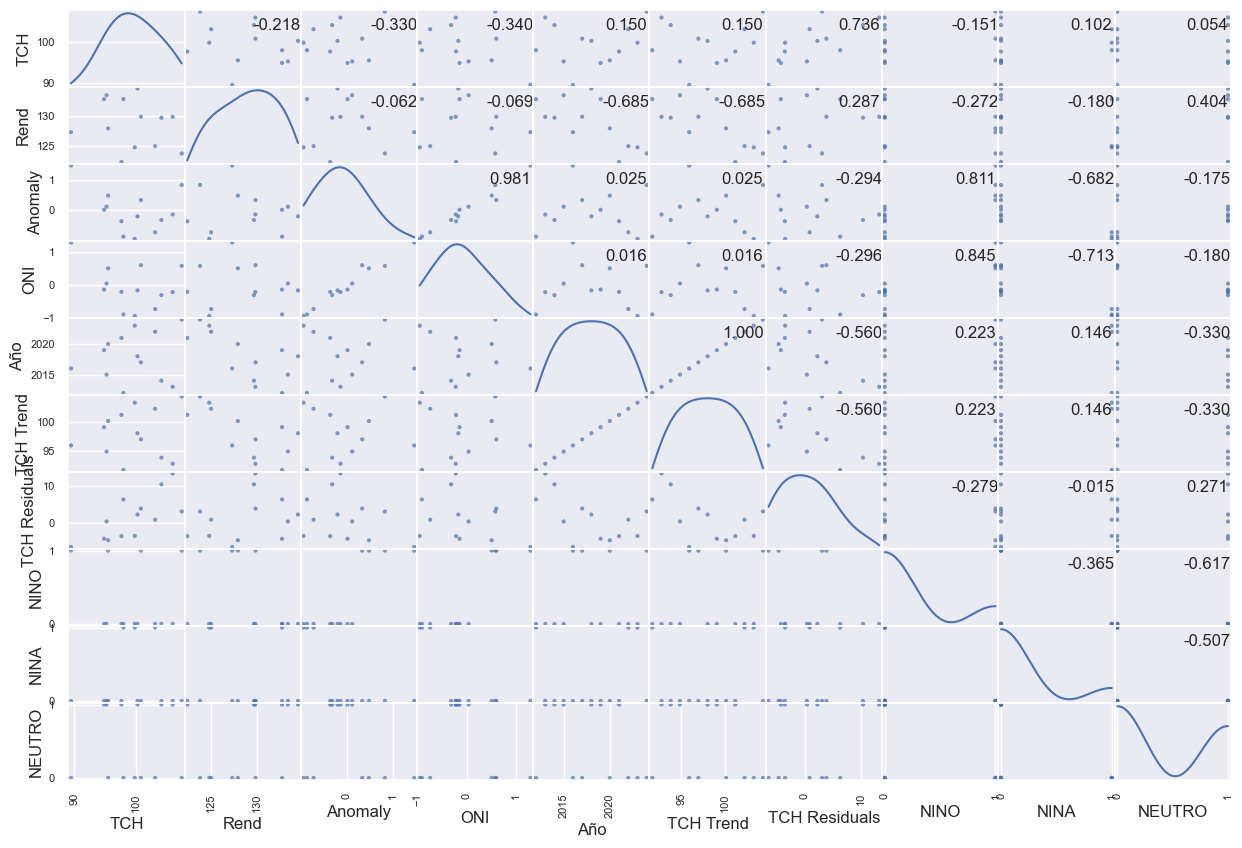

In [12]:
axes = scatter_matrix(df, alpha=0.7,figsize=(15, 10), diagonal='kde')
corr = df.corr().to_numpy()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

Las correlaciones importantes con el TCH ocurren con la **Anomalía ONI** de forma moderada.

Las correlaciones importantes con los Residuos de TCH ocurren con: **Anomalía ONI** y los períodos **Neutro y Niño**.

### Efecto del ENSO sobre TCH

Se filtran los años clasificados como **Niño, Niña y Neutro**, para explorar su distribución en estos períodos

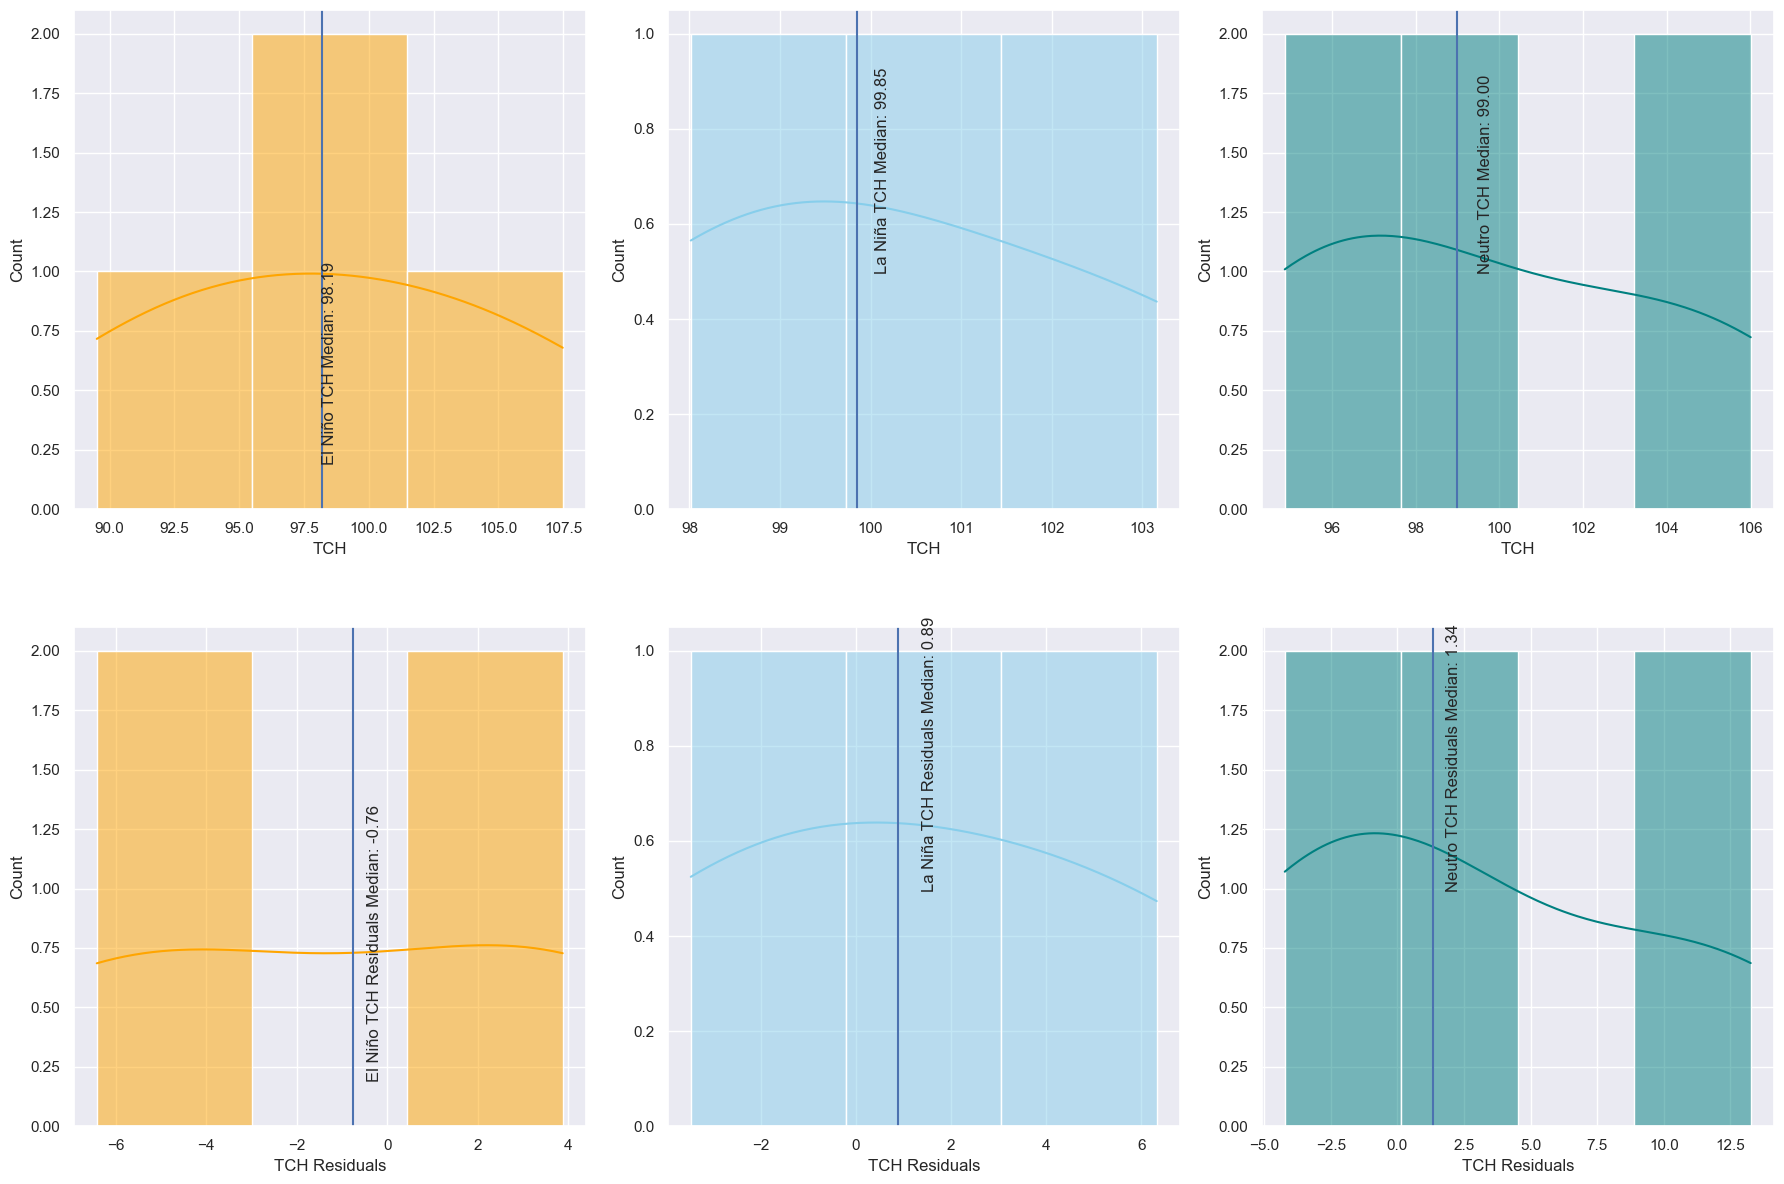

In [13]:
df_niño = df[df['NINO']==1]
df_niña = df[df['NINA']==1]
df_neutro = df[df['NEUTRO']==1]

fig,axs = plt.subplots(2,3,figsize = (18,12))

# El Niño
sns.histplot(data=df_niño, x="TCH", kde=True, color="orange", ax=axs[0,0])
axs[0,0].axvline(df_niño['TCH'].median(),0,1, color ='b')
axs[0,0].text(df_niño['TCH'].median()+0.02,0.2,'El Niño TCH Median: {:.2f}'.format(df_niño['TCH'].median()),rotation=90)

# La Niña
sns.histplot(data=df_niña, x="TCH", kde=True, color="skyblue", ax=axs[0,1])
axs[0,1].axvline(df_niña['TCH'].median(),0,1, color ='b')
axs[0,1].text(df_niña['TCH'].median()+0.2,0.5,'La Niña TCH Median: {:.2f}'.format(df_niña['TCH'].median()),rotation=90)

# Neutro
sns.histplot(data=df_neutro, x="TCH", kde=True, color="teal", ax=axs[0,2])
axs[0,2].axvline(df_neutro['TCH'].median(),0,1, color ='b')
axs[0,2].text(df_neutro['TCH'].median()+0.5,1,'Neutro TCH Median: {:.2f}'.format(df_neutro['TCH'].median()),rotation=90)

# El Niño
sns.histplot(data=df_niño, x="TCH Residuals", kde=True, color="orange", ax=axs[1,0])
axs[1,0].axvline(df_niño['TCH Residuals'].median(),0,1, color ='b')
axs[1,0].text(df_niño['TCH Residuals'].median()+0.3,0.2,'El Niño TCH Residuals Median: {:.2f}'.format(df_niño['TCH Residuals'].median()),rotation=90)

# La Niña
sns.histplot(data=df_niña, x="TCH Residuals", kde=True, color="skyblue", ax=axs[1,1])
axs[1,1].axvline(df_niña['TCH Residuals'].median(),0,1, color ='b')
axs[1,1].text(df_niña['TCH Residuals'].median()+0.5,0.5,'La Niña TCH Residuals Median: {:.2f}'.format(df_niña['TCH Residuals'].median()),rotation=90)

# Neutro
sns.histplot(data=df_neutro, x="TCH Residuals", kde=True, color="teal", ax=axs[1,2])
axs[1,2].axvline(df_neutro['TCH Residuals'].median(),0,1, color ='b')
axs[1,2].text(df_neutro['TCH Residuals'].median()+0.5,1,'Neutro TCH Residuals Median: {:.2f}'.format(df_neutro['TCH Residuals'].median()),rotation=90)

fig.tight_layout()

### Boxplot Efecto Anomalía ONI (Completo)
En este análisis se presentan los escenarios:
- El Niño (ONI mayor a 0.5)
- Neutro (ONI entre -0.5 y 0.5)
- La Niña (ONI menor a -0.5)

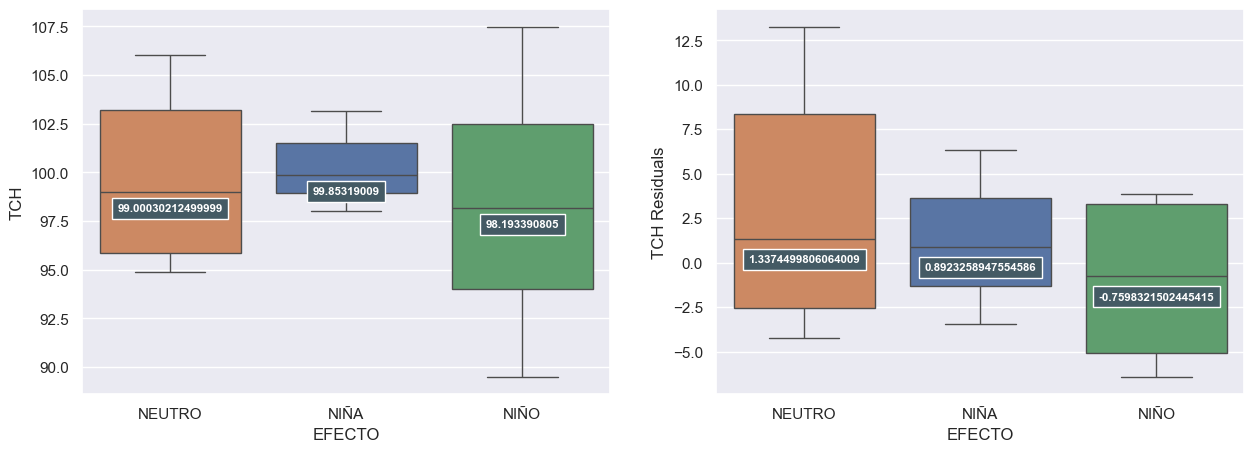

In [14]:
df_boxplot = df

conditions = [
    (df['NINO'] == 1),
    (df['NINA'] == 1),
    (df['NEUTRO'] == 1)]
choices = ['NIÑO', 'NIÑA', 'NEUTRO']
df_boxplot['EFECTO'] = np.select(conditions, choices, default='black')


fig, ax =plt.subplots(1,2, figsize=(15, 5))
plt.set_loglevel('WARNING')

my_pal = {"NEUTRO": "g", "NIÑA": "b", "NIÑO":"r"}

# TCH
medians = df_boxplot.groupby(['EFECTO'])['TCH'].median()
means = df_boxplot.groupby(['EFECTO'])['TCH'].mean()
df_TCH_full = pd.concat([medians,means],axis=1)
df_TCH_full.columns = ['TCH Medians', 'TCH Means']
box_plot = sns.boxplot(data=df_boxplot, x="EFECTO", y="TCH",ax=ax[0],hue="EFECTO",order=df_TCH_full.index)

vertical_offset = df_boxplot['TCH'].median() * 0.01 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] - vertical_offset,medians.iloc[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold',bbox=dict(facecolor='#445A64'))

# Diferenciales de TCH
medians = df_boxplot.groupby(['EFECTO'])['TCH Residuals'].median()
means = df_boxplot.groupby(['EFECTO'])['TCH Residuals'].mean()
df_TCHR_full = pd.concat([medians,means],axis=1)
df_TCHR_full.columns = ['TCH Residuals Medians', 'TCH Residuals Means']
box_plot = sns.boxplot(data=df_boxplot, x="EFECTO", y="TCH Residuals",ax=ax[1],hue="EFECTO",order=df_TCHR_full.index)

vertical_offset = df_boxplot['TCH Residuals'].median() * 1.5 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] - vertical_offset,medians.iloc[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold',bbox=dict(facecolor='#445A64'))

df_TCH_full = pd.concat([df_TCH_full,df_TCHR_full],axis=1)

In [15]:
df_TCH_full

,TCH Medians,TCH Means,TCH Residuals Medians,TCH Residuals Means
EFECTO,,,,
NEUTRO,99.000302,99.723636,1.337450,3.095164
NIÑA,99.853190,100.342920,0.892326,1.247299
NIÑO,98.193391,98.344198,-0.759832,-1.015761


### Boxplot Efecto Anomalía ONI (Fuerte)
En este análisis se presentan los escenarios:
- El Niño (ONI mayor a 1)
- Neutro (ONI entre -1 y 1)
- La Niña (ONI menor a -1)

In [16]:
threshold = 1.0
df['NINO'] = (df['ONI'] > threshold).astype(int)
df['NINA'] = (df['ONI'] < -threshold).astype(int)
df['NEUTRO'] = ((df['ONI'] <= threshold) & (df['ONI'] >= -threshold)).astype(int)

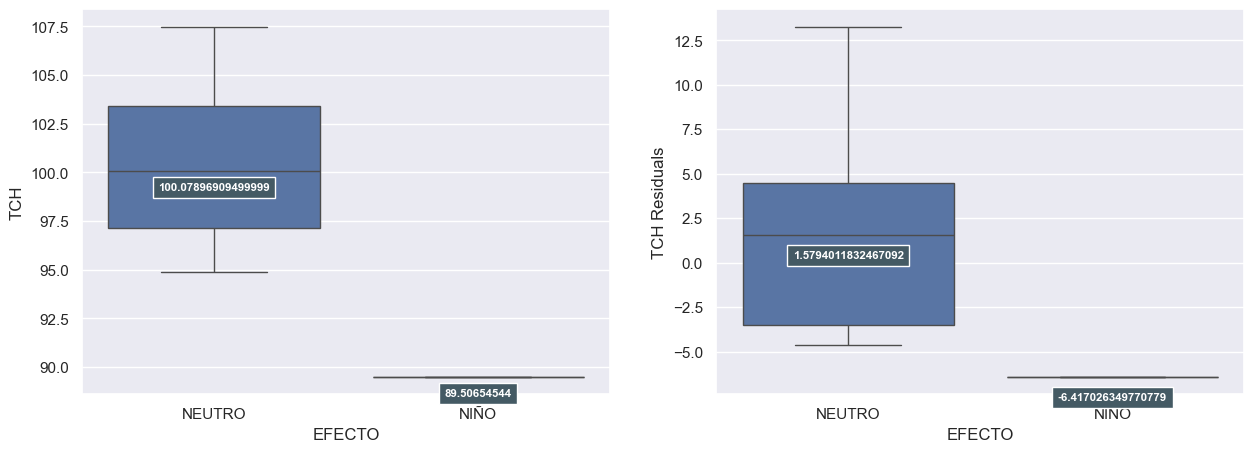

In [17]:
df_boxplot = df

conditions = [
    (df['NINO'] == 1),
    (df['NINA'] == 1),
    (df['NEUTRO'] == 1)]
choices = ['NIÑO', 'NIÑA', 'NEUTRO']
df_boxplot['EFECTO'] = np.select(conditions, choices, default='black')


fig, ax =plt.subplots(1,2, figsize=(15, 5))
plt.set_loglevel('WARNING')

my_pal = {"NEUTRO": "g", "NIÑA": "b", "NIÑO":"r"}

# TCH
medians = df_boxplot.groupby(['EFECTO'])['TCH'].median()
means = df_boxplot.groupby(['EFECTO'])['TCH'].mean()
df_TCH_fuerte = pd.concat([medians,means],axis=1)
df_TCH_fuerte.columns = ['TCH Medians', 'TCH Means']
box_plot = sns.boxplot(data=df_boxplot, x="EFECTO", y="TCH",ax=ax[0],hue="EFECTO",order=df_TCH_fuerte.index)

vertical_offset = df_boxplot['TCH'].median() * 0.01 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] - vertical_offset,medians.iloc[xtick], 
            horizontalalignment='center',size='x-small',color='white',weight='semibold',bbox=dict(facecolor='#445A64'))

# Diferenciales de TCH
medians = df_boxplot.groupby(['EFECTO'])['TCH Residuals'].median()
means = df_boxplot.groupby(['EFECTO'])['TCH Residuals'].mean()
df_TCHR_fuerte = pd.concat([medians,means],axis=1)
df_TCHR_fuerte.columns = ['TCH Residuals Medians', 'TCH Residuals Means']
box_plot = sns.boxplot(data=df_boxplot, x="EFECTO", y="TCH Residuals",ax=ax[1],hue="EFECTO",order=df_TCHR_fuerte.index)

vertical_offset = df_boxplot['TCH Residuals'].median() * 1.5 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] - vertical_offset,medians.iloc[xtick], 
            horizontalalignment='center',size='x-small',color='white',weight='semibold',bbox=dict(facecolor='#445A64'))

df_TCH_fuerte = pd.concat([df_TCH_fuerte,df_TCHR_fuerte],axis=1)

In [18]:
df_TCH_fuerte

,TCH Medians,TCH Means,TCH Residuals Medians,TCH Residuals Means
EFECTO,,,,
NEUTRO,100.078969,100.270069,1.579401,2.055572
NIÑO,89.506545,89.506545,-6.417026,-6.417026


### Interpretación de Boxplots

Se muestran resultados para TCH y Residuos (diferencial) de TCH debidos a años Niño, Niña o Neutros. Se entiende que el efecto de un año **Niño/Niña/Neutro** es observable en la caña del siguiente año.

In [19]:
df_TCH_full

,TCH Medians,TCH Means,TCH Residuals Medians,TCH Residuals Means
EFECTO,,,,
NEUTRO,99.000302,99.723636,1.337450,3.095164
NIÑA,99.853190,100.342920,0.892326,1.247299
NIÑO,98.193391,98.344198,-0.759832,-1.015761


In [20]:
df_TCH_fuerte

,TCH Medians,TCH Means,TCH Residuals Medians,TCH Residuals Means
EFECTO,,,,
NEUTRO,100.078969,100.270069,1.579401,2.055572
NIÑO,89.506545,89.506545,-6.417026,-6.417026


#### Para el **valor absoluto de TCH** resume lo siguiente:
- En años **Niño Típicos** el TCH se centraría alrededor de **98.34**
- En **Niños Fuertes** el TCH podría alcanzar hasta **89.50**
- En años **Neutros** el TCH se centraría entre **99.72** y **100.27**
- En años **Niña Típicos** el TCH se centraría en **100.34**
- En años **Niña Fuertes** no tenemos aún datos históricos.

Estos valores son para el promedio actual de TCH, sin embargo como se explicó al inicio, este valor está afectado por la tendencia creciente desde el inicio del período de análisis y que se deben a mejoras graduales que se han realizado en el proceso de producción de caña. Por ello es más útil el uso del **diferencial de TCH** , ya que puede utilizarse para *sumar/restar* sobre las metas actuales.

#### Para los **Residuos (Diferencial) de TCH** resume lo siguiente:
- En años **Niño Típicos** el diferencial de TCH se centraría alrededor de **-1.02**,
- En años **Niños Fuertes** el diferencial de TCH podría alcanzar hasta **-6.42**
- En años **Neutros** el diferencial de TCH se centraría entre **+2.06 y +3.10**
- En años **Niña Típicos** el diferencial de TCH se centraría en **+1.25**
- En años **Niña Fuertes** aún no tenemos datos históricos

### Prueba Estadística Two Sample t-Test para Medias Distintas

Los boxplots muestran que existe intersección entre las distribuciones de TCH para años Niño, Niña y Neutro. Esto mismo ocurre con los residuos. Por lo que se hace necesario hacer una pruebas estadísticas de hipótesis para verificar si realmente la diferencia observada tiene significancia estadística.

Para ello se conducirán pruebas de hipótesis, tanto para los valores de TCH absolutos como para los Residuos.

### Pruebas de Hipótesis sobre Valores Absolutos de TCH

In [21]:
df = pd.concat([oni_df,ni_yield_df],axis=1)
df = df[['TCH','Rend','Anomaly','ONI','Año']]
df['Anomaly'] = df.Anomaly.shift(1)
df['ONI'] = df.ONI.shift(1)
df = df.iloc[1:]

threshold = 0.5
df['TCH Trend'] = ex_hat.values
df['TCH Residuals'] = df['TCH'] - df['TCH Trend']
df['NINO'] = (df['ONI'] > threshold).astype(int)
df['NINA'] = (df['ONI'] < -threshold).astype(int)
df['NEUTRO'] = ((df['ONI'] <= threshold) & (df['ONI'] >= -threshold)).astype(int)
df

,TCH,Rend,Anomaly,ONI,Año,TCH Trend,TCH Residuals,NINO,NINA,NEUTRO
Year,,,,,,,,,,
2006-12-31,83.701990,NaN,0.041667,0.168611,2006,85.350073,-1.648083,0,0,1
2007-12-31,90.596794,NaN,0.087500,-0.075000,2007,86.407423,4.189372,0,0,1
2008-12-31,82.442004,NaN,-0.617500,-0.396389,2008,87.464772,-5.022768,0,0,1
2009-12-31,78.479834,NaN,-0.784167,-0.853889,2009,88.522122,-10.042289,0,1,0
2010-12-31,86.777073,NaN,0.285833,0.088889,2010,89.579472,-2.802400,0,0,1
2011-12-31,87.713152,NaN,-0.486667,-0.215833,2011,90.636822,-2.923671,0,0,1
2012-12-31,98.015574,132.766181,-0.864167,-0.907500,2012,91.694172,6.321402,0,1,0
2013-12-31,106.013302,129.845533,-0.140000,-0.221389,2013,92.751522,13.261780,0,0,1
2014-12-31,104.181965,129.688500,-0.319167,-0.315556,2014,93.808872,10.373093,0,0,1


#### Primera Prueba de Hipótesis: La media de TCH en año Niño es menor a la media de TCH en año Niña
- Sea $\mu_1$ la media de TCH en años Niño, $\mu_2$ la media de TCH en años Niña.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \geq \mu_2$

In [22]:
ttest_ind(df[df['NINO']==1]['TCH'],df[df['NINA']==1]['TCH'],alternative = 'larger',usevar = 'unequal', value = 0)

(0.5130845767928529, 0.3142467964572251, 5.317817431584702)

Con un nivel de confianza del **68%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de TCH en años Niño es mayor que la media de TCH en años Niña.***

#### Segunda Prueba de Hipótesis: La media de TCH en año Niño es mayor a la media de TCH en año Neutro
- Sea $\mu_1$ la media de TCH en años Niño, $\mu_2$ la media de TCH en años Neutros.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \geq \mu_2$

In [23]:
ttest_ind(df[df['NINO']==1]['TCH'],df[df['NEUTRO']==1]['TCH'],alternative = 'larger',usevar = 'unequal', value = 0)

(1.0479503957861513, 0.1688427428356609, 5.611403501996901)

Con un nivel de confianza del **83%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de TCH en años Niño es mayor que la media de TCH en años Neutros.***

#### Tercera Prueba de Hipótesis: La media de TCH en año Niña es menor a la media de TCH en año Neutro
- Sea $\mu_1$ la media de TCH en años Niña, $\mu_2$ la media de TCH en años Neutros.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \leq \mu_2$

In [24]:
ttest_ind(df[df['NINA']==1]['TCH'],df[df['NEUTRO']==1]['TCH'],alternative = 'smaller',usevar = 'unequal', value = 0)

(0.21073793836209495, 0.5785341654138924, 4.196723623908603)

Con un nivel de confianza del **42%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de TCH en años Niña es menor que la media de TCH en años Neutros.***

### Pruebas de Hipótesis sobre Valores Residuales (Diferenciales) de TCH

#### Primera Prueba de Hipótesis: La media de Diferenciales de TCH en año Niño es mayor a la media de Diferenciales de TCH en año Niña
- Sea $\mu_1$ la media de Diferenciales de TCH en años Niño, $\mu_2$ la media de Diferenciales de TCH en años Niña.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \geq \mu_2$

In [25]:
ttest_ind(df[df['NINO']==1]['TCH Residuals'],df[df['NINA']==1]['TCH Residuals'],alternative = 'larger',usevar = 'unequal', value = 0)

(0.12867148941849033, 0.4510570801303794, 5.598697228901611)

Con un nivel de confianza del **54%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de Diferenciales de TCH en años Niño es mayor que la media de Diferenciales de TCH en años Niña.***

#### Segunda Prueba de Hipótesis: La media de Diferenciales de TCH en año Niño es menor a la media de Diferenciales de TCH en año Neutro
- Sea $\mu_1$ la media de Diferenciales de TCH en años Niño, $\mu_2$ la media de Diferenciales de TCH en años Neutros.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \leq \mu_2$

In [26]:
ttest_ind(df[df['NINO']==1]['TCH Residuals'],df[df['NEUTRO']==1]['TCH Residuals'],alternative = 'smaller',usevar = 'unequal', value = 0)

(-0.610281183592674, 0.2816863323309825, 6.197012948462338)

Con un nivel de confianza del **71%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de Diferenciales de TCH en años Niño es mayor que la media de Diferenciales de TCH en años Neutros.***

#### Tercera Prueba de Hipótesis: La media de Diferenciales de TCH en año Niña es menor a la media de Diferenciales de TCH en año Neutro
- Sea $\mu_1$ la media de Diferenciales de TCH en años Niña, $\mu_2$ la media de Diferenciales de TCH en años Neutros.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \leq \mu_2$

In [27]:
ttest_ind(df[df['NINA']==1]['TCH Residuals'],df[df['NEUTRO']==1]['TCH Residuals'],alternative = 'smaller',usevar = 'unequal', value = 0)

(-0.6424610061459609, 0.27495775642931053, 4.813424287514685)

Con un nivel de confianza del **72%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de TCH en años Niña es menor que la media de TCH en años Neutros.***